# Phishing Detection XGBoost Model #

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, accuracy_score, 
                           precision_score, recall_score, f1_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Set random seed for reproducible results
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 1. Data Visualization & Preprocessing ###

In [5]:
# Load and view the dataset
df = pd.read_csv('data/dataset_phishing.csv')

# Basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Look at the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

Dataset shape: (11430, 89)
Number of rows: 11430
Number of columns: 89

First 5 rows of the dataset:
                                                 url  length_url  \
0              http://www.crestonwood.com/router.php          37   
1  http://shadetreetechnology.com/V4/validation/a...          77   
2  https://support-appleld.com.secureupdate.duila...         126   
3                                 http://rgipt.ac.in          18   
4  http://www.iracing.com/tracks/gateway-motorspo...          55   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               19   0        3           0      0      0       0      0  ...   
1               23   1        1           0      0      0       0      0  ...   
2               50   1        4           1      0      1       2      0  ...   
3               11   0        2           0      0      0       0      0  ...   
4               15   0        2           2      0      0       0      0  ...   

   

In [6]:
# Check the target variable 
target_counts = df['status'].value_counts()
target_pct = df['status'].value_counts(normalize=True) * 100

print(f"Class Distribution:")
for status, count in target_counts.items():
    pct = target_pct[status]
    print(f"  {status:>12}: {count:>6,} ({pct:5.1f}%)")

Class Distribution:
    legitimate:  5,715 ( 50.0%)
      phishing:  5,715 ( 50.0%)


In [7]:
# Check for missing values
print("\nChecking for missing values:")
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values found:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found.")


Checking for missing values:
No missing values found.


In [8]:
# dataset statistics
print(df.describe())

         length_url  length_hostname            ip       nb_dots  \
count  11430.000000     11430.000000  11430.000000  11430.000000   
mean      61.126684        21.090289      0.150569      2.480752   
std       55.297318        10.777171      0.357644      1.369686   
min       12.000000         4.000000      0.000000      1.000000   
25%       33.000000        15.000000      0.000000      2.000000   
50%       47.000000        19.000000      0.000000      2.000000   
75%       71.000000        24.000000      0.000000      3.000000   
max     1641.000000       214.000000      1.000000     24.000000   

         nb_hyphens         nb_at         nb_qm        nb_and    nb_or  \
count  11430.000000  11430.000000  11430.000000  11430.000000  11430.0   
mean       0.997550      0.022222      0.141207      0.162292      0.0   
std        2.087087      0.155500      0.364456      0.821337      0.0   
min        0.000000      0.000000      0.000000      0.000000      0.0   
25%        0.0000

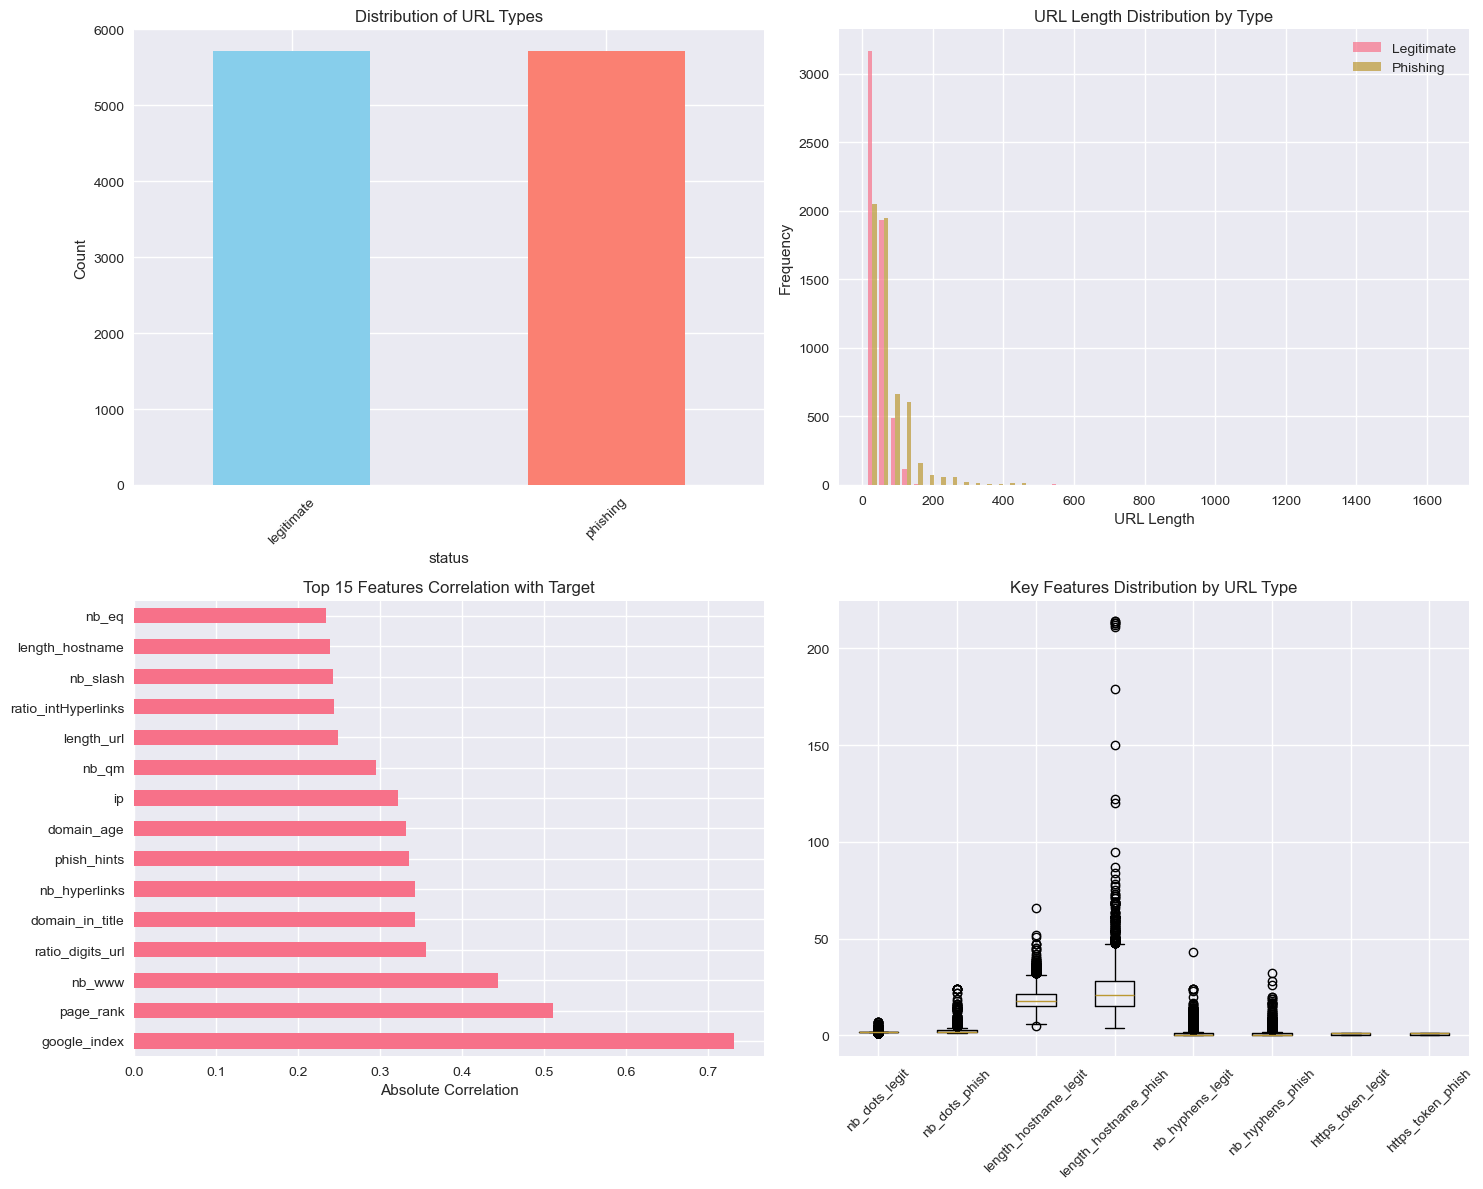

In [9]:
# EDA Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Target distribution
target_counts.plot(kind='bar', ax=axes[0,0], color=['skyblue', 'salmon'])
axes[0,0].set_title('Distribution of URL Types')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Feature distribution example - URL length
axes[0,1].hist([df[df['status']=='legitimate']['length_url'], 
                df[df['status']=='phishing']['length_url']], 
               bins=50, alpha=0.7, label=['Legitimate', 'Phishing'])
axes[0,1].set_title('URL Length Distribution by Type')
axes[0,1].set_xlabel('URL Length')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# 3. Correlation with target for key features
# Encode target for correlation analysis
df_corr = df.copy()
le_temp = LabelEncoder()
df_corr['status_encoded'] = le_temp.fit_transform(df_corr['status'])

# Select numerical features for correlation
numerical_features = df_corr.select_dtypes(include=[np.number]).columns
correlation_with_target = df_corr[numerical_features].corr()['status_encoded'].abs().sort_values(ascending=False)[1:16]

correlation_with_target.plot(kind='barh', ax=axes[1,0])
axes[1,0].set_title('Top 15 Features Correlation with Target')
axes[1,0].set_xlabel('Absolute Correlation')

# 4. Feature distribution comparison
key_features = ['nb_dots', 'length_hostname', 'nb_hyphens', 'https_token']
feature_data = []
labels = []
for feature in key_features:
    feature_data.extend([df[df['status']=='legitimate'][feature].values,
                        df[df['status']=='phishing'][feature].values])
    labels.extend([f'{feature}_legit', f'{feature}_phish'])

axes[1,1].boxplot(feature_data, labels=labels)
axes[1,1].set_title('Key Features Distribution by URL Type')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [10]:
# Detailed feature analysis
print(f"\nDetailed Feature Analysis:")
print(f"Numerical features: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical features: {len(df.select_dtypes(include=['object']).columns)}")

# Statistical summary for key features
key_features_analysis = ['length_url', 'nb_dots', 'nb_hyphens', 'https_token', 'nb_subdomains']
print(f"\nKey Features Statistical Summary:")
for feature in key_features_analysis:
    print(f"\n{feature}:")
    legitimate_stats = df[df['status']=='legitimate'][feature].describe()
    phishing_stats = df[df['status']=='phishing'][feature].describe()
    print(f"  Legitimate - Mean: {legitimate_stats['mean']:.2f}, Std: {legitimate_stats['std']:.2f}")
    print(f"  Phishing   - Mean: {phishing_stats['mean']:.2f}, Std: {phishing_stats['std']:.2f}")


Detailed Feature Analysis:
Numerical features: 87
Categorical features: 2

Key Features Statistical Summary:

length_url:
  Legitimate - Mean: 47.38, Std: 27.86
  Phishing   - Mean: 74.87, Std: 70.44

nb_dots:
  Legitimate - Mean: 2.20, Std: 0.66
  Phishing   - Mean: 2.76, Std: 1.78

nb_hyphens:
  Legitimate - Mean: 1.21, Std: 2.42
  Phishing   - Mean: 0.79, Std: 1.66

https_token:
  Legitimate - Mean: 0.56, Std: 0.50
  Phishing   - Mean: 0.67, Std: 0.47

nb_subdomains:
  Legitimate - Mean: 2.16, Std: 0.56
  Phishing   - Mean: 2.30, Std: 0.70


In [11]:
# Convert text labels to numbers using LabelEncoder for target variable
label_encoder = LabelEncoder()
df['status_encoded'] = label_encoder.fit_transform(df['status'])

print("Label encoding:")
print("Original labels:", label_encoder.classes_)
print("Encoded as:", label_encoder.transform(label_encoder.classes_))
print("'legitimate' = 0, 'phishing' = 1")

Label encoding:
Original labels: ['legitimate' 'phishing']
Encoded as: [0 1]
'legitimate' = 0, 'phishing' = 1


In [12]:
# Separate features (X) from target (y)
# Features = all columns except 'status', 'status_encoded', and 'url' (if it exists)
feature_columns = [col for col in df.columns if col not in ['status', 'status_encoded', 'url']]
X = df[feature_columns]  # Features
y = df['status_encoded']  # Target

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Number of features we'll use: {len(feature_columns)}")


Features (X) shape: (11430, 87)
Target (y) shape: (11430,)
Number of features we'll use: 87


In [13]:
# Some feature examples
print("\nExample features:")
for i, col in enumerate(feature_columns[:10]):  # Show first 10 features
    print(f"{i+1:2d}. {col}")


Example features:
 1. length_url
 2. length_hostname
 3. ip
 4. nb_dots
 5. nb_hyphens
 6. nb_at
 7. nb_qm
 8. nb_and
 9. nb_or
10. nb_eq


In [14]:
# Handle outliers
print(f"\nOutlier Detection and Treatment:")
numerical_cols = df.select_dtypes(include=[np.number]).columns

outlier_summary = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_summary[col] = outliers

# Show features with most outliers
outlier_df = pd.DataFrame(list(outlier_summary.items()), columns=['Feature', 'Outlier_Count'])
outlier_df = outlier_df.sort_values('Outlier_Count', ascending=False).head(10)
print("Top 10 features with most outliers:")
print(outlier_df)


Outlier Detection and Treatment:
Top 10 features with most outliers:
            Feature  Outlier_Count
78  domain_in_title           2562
33    prefix_suffix           2314
64  ratio_extErrors           2149
83      web_traffic           2138
50      phish_hints           2041
70   ratio_extMedia           2012
2                ip           1721
10    nb_underscore           1695
9             nb_eq           1564
6             nb_qm           1555


In [77]:
# Data Preparation
df_prepared = df.copy()


In [79]:
# Encode target variable
label_encoder = LabelEncoder()
df_prepared['status_encoded'] = label_encoder.fit_transform(df_prepared['status'])
print(f"\nTarget encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
print(f"Total features available: {df_prepared.shape[1] - 2} (excluding 'status' and 'url' columns)")
df_prepared.shape


Target encoding: {'legitimate': 0, 'phishing': 1}
Total features available: 88 (excluding 'status' and 'url' columns)


(11430, 90)

## 2. Feature Selection ##

In [18]:
# Prepare features for selection
feature_columns = [col for col in df_prepared.columns 
                  if col not in ['status', 'status_encoded', 'url']]
X = df_prepared[feature_columns]
y = df_prepared['status_encoded']

print(f"Starting with {X.shape[1]} features")

Starting with 87 features


In [19]:
# Method 1: Correlation-based feature removal
print("\nCorrelation-based Feature Removal")
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

highly_correlated = [column for column in upper_triangle.columns 
                    if any(upper_triangle[column] > 0.95)]
print(f"Highly correlated features to remove: {len(highly_correlated)}")
X_reduced = X.drop(columns=highly_correlated)
print(f"Features after correlation removal: {X_reduced.shape[1]}")


Correlation-based Feature Removal
Highly correlated features to remove: 1
Features after correlation removal: 86


In [20]:
# Method 2: Statistical feature selection
print("\nStatistical Feature Selection (SelectKBest)")
selector_stats = SelectKBest(score_func=f_classif, k=50)
X_stats_selected = selector_stats.fit_transform(X_reduced, y)
selected_features_stats = X_reduced.columns[selector_stats.get_support()]
print(f"Top 50 features selected by statistical test")


Statistical Feature Selection (SelectKBest)
Top 50 features selected by statistical test


In [21]:
# Method 3: Tree-based feature importance
print("\nTree-based Feature Importance")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_selector.fit(X_reduced, y)
feature_importance = pd.DataFrame({
    'feature': X_reduced.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)


Tree-based Feature Importance


In [22]:
# Select top features based on importance
top_features_rf = feature_importance.head(50)['feature'].tolist()
print(f"Top 50 features selected by Random Forest importance")

Top 50 features selected by Random Forest importance


In [23]:
# Method 4: Recursive Feature Elimination
print("\nRecursive Feature Elimination (RFE)")
estimator = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
rfe_selector = RFE(estimator=estimator, n_features_to_select=50)
X_rfe_selected = rfe_selector.fit_transform(X_reduced, y)
selected_features_rfe = X_reduced.columns[rfe_selector.support_]
print(f"50 features selected by RFE")


Recursive Feature Elimination (RFE)
50 features selected by RFE


In [83]:
# Combine selection methods (ensemble approach)
print("\nEnsemble Feature Selection")
all_selected = set(selected_features_stats) | set(top_features_rf) | set(selected_features_rfe)
feature_votes = {}
for feature in all_selected:
    votes = 0
    if feature in selected_features_stats: votes += 1
    if feature in top_features_rf: votes += 1
    if feature in selected_features_rfe: votes += 1
    feature_votes[feature] = votes

# Select features that were chosen by at least 2 methods
final_features = [feature for feature, votes in feature_votes.items() if votes >= 2]
print(f"Final features selected (voted by 2+ methods): {len(final_features)}")

X_final = X_reduced[final_features]
print(f"Final feature set shape: {X_final.shape}")

print(X_final[final_features])


Ensemble Feature Selection
Final features selected (voted by 2+ methods): 50
Final feature set shape: (11430, 50)
       domain_in_brand  ratio_intHyperlinks  domain_in_title  nb_percent  \
0                    0             0.529412                0           0   
1                    0             0.966667                1           0   
2                    0             1.000000                1           0   
3                    0             0.973154                1           0   
4                    0             0.470588                0           0   
...                ...                  ...              ...         ...   
11425                0             0.884422                0           0   
11426                0             1.000000                1           1   
11427                1             0.470588                0           0   
11428                0             0.375000                1           0   
11429                0             0.428571      

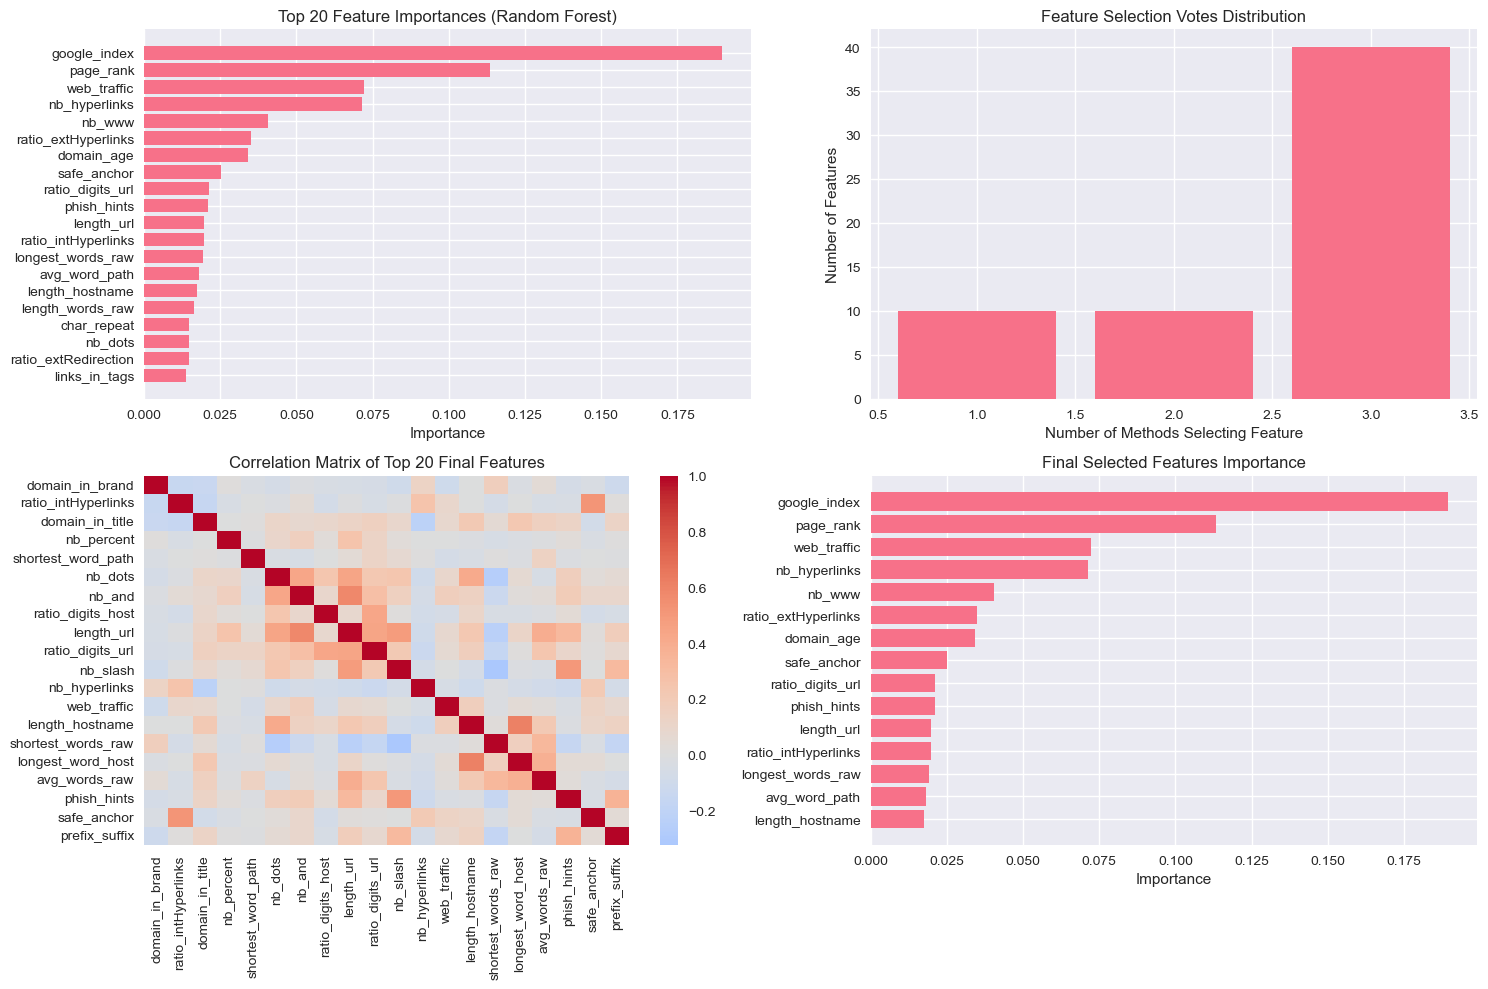

In [25]:
# Visualize feature selection results
plt.figure(figsize=(15, 10))

# Feature importance plot
plt.subplot(2, 2, 1)
top_20_features = feature_importance.head(20)
plt.barh(range(len(top_20_features)), top_20_features['importance'])
plt.yticks(range(len(top_20_features)), top_20_features['feature'])
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()

# Feature selection votes
plt.subplot(2, 2, 2)
vote_counts = pd.Series(feature_votes).value_counts().sort_index()
plt.bar(vote_counts.index, vote_counts.values)
plt.title('Feature Selection Votes Distribution')
plt.xlabel('Number of Methods Selecting Feature')
plt.ylabel('Number of Features')

# Correlation heatmap of final features (top 20)
plt.subplot(2, 2, 3)
corr_final = X_final[final_features[:20]].corr()
sns.heatmap(corr_final, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Top 20 Final Features')

# Feature importance comparison
plt.subplot(2, 2, 4)
final_importance = feature_importance[feature_importance['feature'].isin(final_features)].head(15)
plt.barh(range(len(final_importance)), final_importance['importance'])
plt.yticks(range(len(final_importance)), final_importance['feature'])
plt.title('Final Selected Features Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## 3. Model Selection & Training ##

In [27]:
# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

print(f"Data split completed:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples") 
print(f"Test: {X_test.shape[0]} samples")

Data split completed:
Training: 6858 samples
Validation: 2286 samples
Test: 2286 samples


In [28]:
# Baseline XGBoost Model
print("\nBaseline XGBoost Training")

baseline_model = XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    early_stopping_rounds=10,
    verbose=False
)

print("Training baseline XGBoost model...")
baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


Baseline XGBoost Training
Training baseline XGBoost model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
# Evaluate baseline model
y_val_pred_baseline = baseline_model.predict(X_val)
y_val_pred_proba_baseline = baseline_model.predict_proba(X_val)[:, 1]

baseline_accuracy = accuracy_score(y_val, y_val_pred_baseline)
baseline_precision = precision_score(y_val, y_val_pred_baseline)
baseline_recall = recall_score(y_val, y_val_pred_baseline)
baseline_f1 = f1_score(y_val, y_val_pred_baseline)
baseline_auc = roc_auc_score(y_val, y_val_pred_proba_baseline)

print(f"\nBaseline XGBoost Results:")
print(f"Accuracy:  {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall:    {baseline_recall:.4f}")
print(f"F1-Score:  {baseline_f1:.4f}")
print(f"AUC:       {baseline_auc:.4f}")


Baseline XGBoost Results:
Accuracy:  0.9624
Precision: 0.9624
Recall:    0.9624
F1-Score:  0.9624
AUC:       0.9935


In [30]:
# Hyperparameter tuning for XGBoost
print("\nXGBoost Hyperparameter Tuning")

print("Optimizing XGBoost hyperparameters using GridSearchCV...")
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_tuning = XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

grid_search = GridSearchCV(
    estimator=xgb_tuning,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)


XGBoost Hyperparameter Tuning
Optimizing XGBoost hyperparameters using GridSearchCV...


In [31]:
# Combine train and validation for hyperparameter tuning
X_tune = pd.concat([X_train, X_val])
y_tune = pd.concat([pd.Series(y_train), pd.Series(y_val)])

grid_search.fit(X_tune, y_tune)

print(f"\nBest XGBoost parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best XGBoost parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Best cross-validation F1 score: 0.9694


In [32]:
# Final optimized XGBoost model
final_model = grid_search.best_estimator_

In [33]:
# Evaluate optimized model on validation set
print("Evaluating optimized XGBoost model on validation set...")
y_val_pred_tuned = final_model.predict(X_val)
y_val_pred_proba_tuned = final_model.predict_proba(X_val)[:, 1]

tuned_accuracy = accuracy_score(y_val, y_val_pred_tuned)
tuned_precision = precision_score(y_val, y_val_pred_tuned)
tuned_recall = recall_score(y_val, y_val_pred_tuned)
tuned_f1 = f1_score(y_val, y_val_pred_tuned)
tuned_auc = roc_auc_score(y_val, y_val_pred_proba_tuned)

print(f"\nOptimized XGBoost Results:")
print(f"Accuracy:  {tuned_accuracy:.4f} (baseline: {baseline_accuracy:.4f})")
print(f"Precision: {tuned_precision:.4f} (baseline: {baseline_precision:.4f})")
print(f"Recall:    {tuned_recall:.4f} (baseline: {baseline_recall:.4f})")
print(f"F1-Score:  {tuned_f1:.4f} (baseline: {baseline_f1:.4f})")
print(f"AUC:       {tuned_auc:.4f} (baseline: {baseline_auc:.4f})")

Evaluating optimized XGBoost model on validation set...

Optimized XGBoost Results:
Accuracy:  1.0000 (baseline: 0.9624)
Precision: 1.0000 (baseline: 0.9624)
Recall:    1.0000 (baseline: 0.9624)
F1-Score:  1.0000 (baseline: 0.9624)
AUC:       1.0000 (baseline: 0.9935)



Baseline vs Optimized XGBoost Comparison


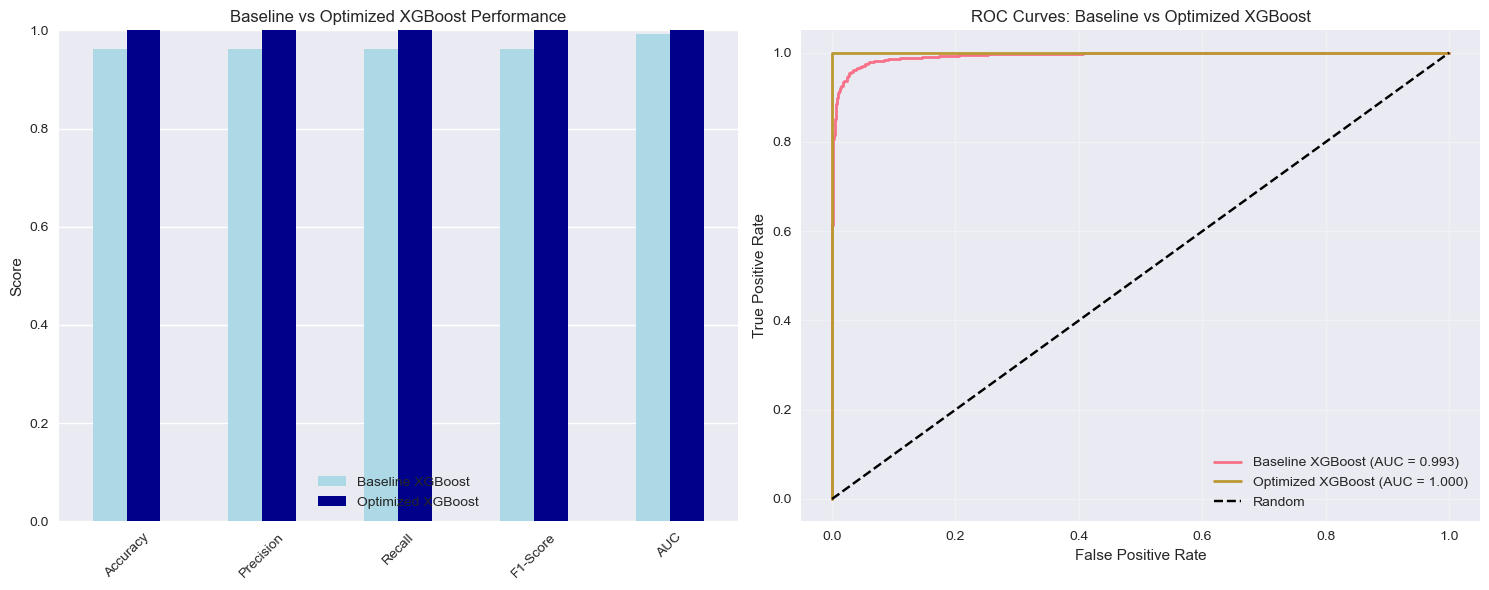

In [34]:
print("\nBaseline vs Optimized XGBoost Comparison")

# Prepare comparison data
comparison_data = {
    'Baseline XGBoost': [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1, baseline_auc],
    'Optimized XGBoost': [tuned_accuracy, tuned_precision, tuned_recall, tuned_f1, tuned_auc]
}
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

comparison_df = pd.DataFrame(comparison_data, index=metrics)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Performance comparison
comparison_df.plot(kind='bar', ax=axes[0], color=['lightblue', 'darkblue'])
axes[0].set_title('Baseline vs Optimized XGBoost Performance')
axes[0].set_ylabel('Score')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 1)

# ROC curves comparison
fpr_baseline, tpr_baseline, _ = roc_curve(y_val, y_val_pred_proba_baseline)
fpr_tuned, tpr_tuned, _ = roc_curve(y_val, y_val_pred_proba_tuned)

axes[1].plot(fpr_baseline, tpr_baseline, label=f'Baseline XGBoost (AUC = {baseline_auc:.3f})', linewidth=2)
axes[1].plot(fpr_tuned, tpr_tuned, label=f'Optimized XGBoost (AUC = {tuned_auc:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves: Baseline vs Optimized XGBoost')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Model Evaluation on Test Set ##

In [36]:
# Final model evaluation on test set
print("Final XGBoost Model Evaluation on Test Set")

# Use the optimized XGBoost model
y_test_pred = final_model.predict(X_test)
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate final metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nFINAL TEST SET PERFORMANCE (Optimized XGBoost):")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f} (False Positive Rate: {1-test_precision:.4f})")
print(f"Recall:    {test_recall:.4f} (False Negative Rate: {1-test_recall:.4f})")
print(f"F1-Score:  {test_f1:.4f}")
print(f"AUC-ROC:   {test_auc:.4f}")

Final XGBoost Model Evaluation on Test Set

FINAL TEST SET PERFORMANCE (Optimized XGBoost):
Accuracy:  0.9689
Precision: 0.9653 (False Positive Rate: 0.0347)
Recall:    0.9729 (False Negative Rate: 0.0271)
F1-Score:  0.9691
AUC-ROC:   0.9938


In [37]:
# Business impact analysis
total_phishing = (y_test == 1).sum()
total_legitimate = (y_test == 0).sum()
false_negatives = ((y_test == 1) & (y_test_pred == 0)).sum()
false_positives = ((y_test == 0) & (y_test_pred == 1)).sum()

print(f"\nBusiness Impact Analysis:")
print(f"Total phishing URLs in test set: {total_phishing}")
print(f"Phishing URLs missed (False Negatives): {false_negatives} ({false_negatives/total_phishing*100:.1f}%)")
print(f"Legitimate URLs blocked (False Positives): {false_positives} ({false_positives/total_legitimate*100:.1f}%)")


Business Impact Analysis:
Total phishing URLs in test set: 1143
Phishing URLs missed (False Negatives): 31 (2.7%)
Legitimate URLs blocked (False Positives): 40 (3.5%)


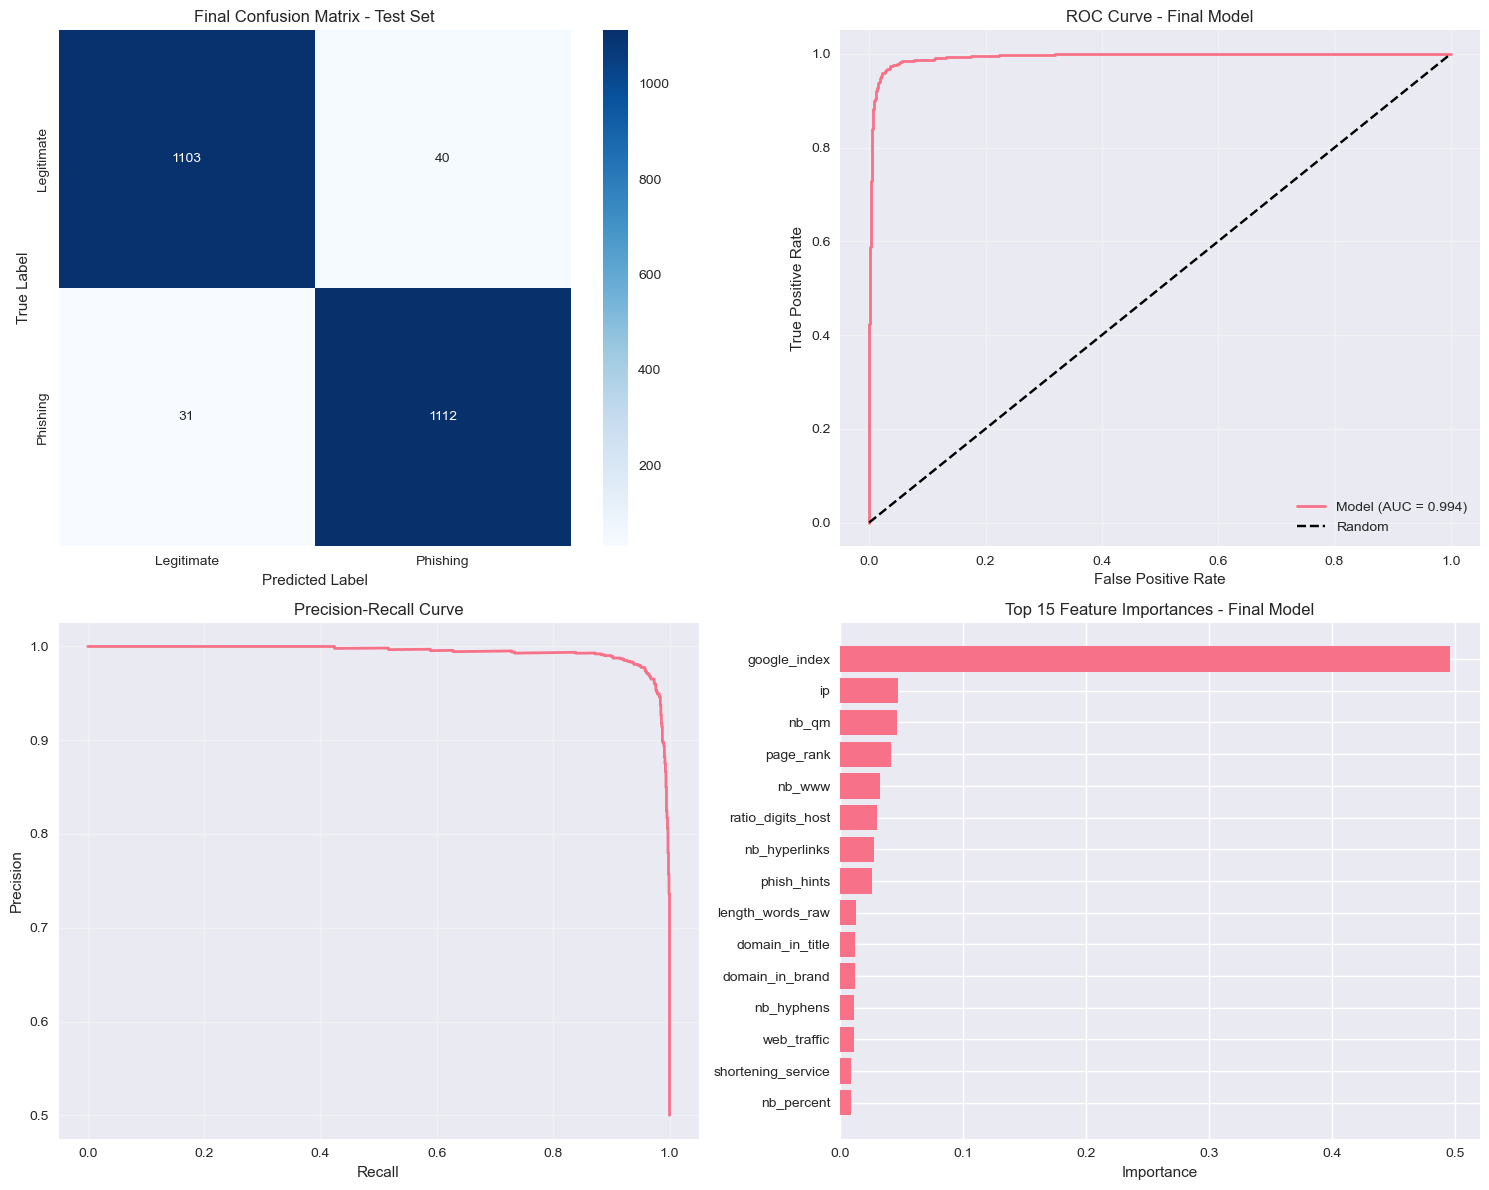

In [38]:
# Detailed evaluation visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
test_cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'], ax=axes[0,0])
axes[0,0].set_title('Final Confusion Matrix - Test Set')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
axes[0,1].plot(fpr, tpr, label=f'Model (AUC = {test_auc:.3f})', linewidth=2)
axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve - Final Model')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_test_pred_proba)
axes[1,0].plot(recall_curve, precision_curve, linewidth=2)
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve')
axes[1,0].grid(True, alpha=0.3)

# Feature Importance
if hasattr(final_model, 'feature_importances_'):
    importance_final = pd.DataFrame({
        'feature': X_final.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    axes[1,1].barh(range(len(importance_final)), importance_final['importance'])
    axes[1,1].set_yticks(range(len(importance_final)))
    axes[1,1].set_yticklabels(importance_final['feature'])
    axes[1,1].set_title('Top 15 Feature Importances - Final Model')
    axes[1,1].set_xlabel('Importance')
    axes[1,1].invert_yaxis()

plt.tight_layout()
plt.show()

In [39]:
# Classification Report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Legitimate', 'Phishing']))


Detailed Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.97      0.97      0.97      1143
    Phishing       0.97      0.97      0.97      1143

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286

